<B>基本概念</B>

基于贝叶斯公式来估计后验概率$P(y|x)$的主要困难在于：类条件概率$P(x|y)$是所有属性上的联合概率，难以从有限的训练样本直接估计而得。

为避开这个障碍，朴素贝叶斯分类器（Naive Bayes classfier）采用了“<B>属性条件独立性假设</B>”：对已知类别，假设所有属性相互独立。换句话说，每个属性独立地对分类结果产生影响。

<div align="center">
    <img src="20240513172552.png" width="300">
</div>


根据条件outlook,temperature,humidity,windy预测是否打球
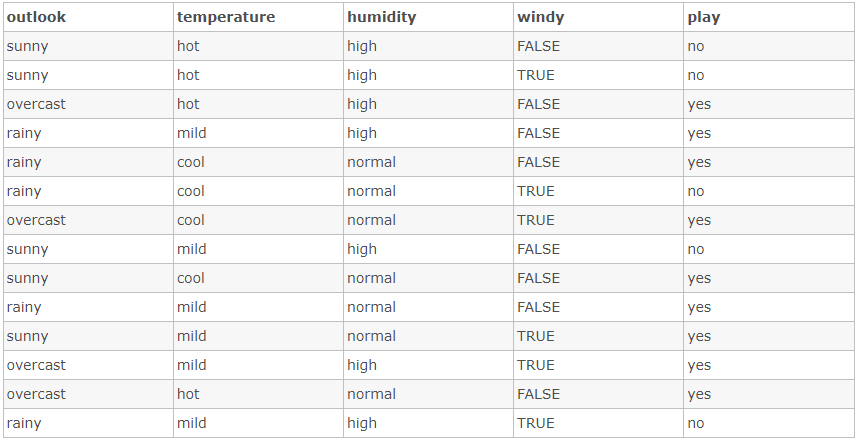

In [5]:
import pandas as pd
import numpy as np

In [6]:
weather = pd.read_csv('data\weather.csv')  #读取数据文件

X = weather.drop(columns=['play'])
y = weather['play']

X

outlook temperature humidity  windy
0      sunny         hot     high  False
1      sunny         hot     high   True
2   overcast         hot     high  False
3      rainy        mild     high  False
4      rainy        cool   normal  False
5      rainy        cool   normal   True
6   overcast        cool   normal   True
7      sunny        mild     high  False
8      sunny        cool   normal  False
9      rainy        mild   normal  False
10     sunny        mild   normal   True
11  overcast        mild     high   True
12  overcast         hot   normal  False
13     rainy        mild     high   True

In [105]:
def nb_fit(X, y):       #模型训练，输入的X是训练样本数据，y是训练样本的类标签
    classes = y.unique()                  # 获取训练样本的所有类别 classes
    class_count = y.value_counts()        # 统计每个类别样本的数量 class_count
    class_prior = class_count / len(y)    # 计算类先验概率 P(y) class_prior
    prior = {}                            # 初始化空类条件概率，Prior 中存储了每个特征在给定类别下的条件概率，以及它们的对应关系，即 (feature,value,class)。

    #计算类条件概率 P(x|y)
    features = X.columns.tolist()
    for feature in features:
        values = X[feature].unique()
        for c in classes:
            for value in values:
                cnt = len(X[(X[feature] == value) & (y == c)])
                prior[(feature,value,c)] = cnt / len(y[y == c])

    return classes, class_prior, prior

In [106]:
classes,class_prior,prior=nb_fit(X,y)

prior

{('outlook', 'sunny', 'no'): 0.6,
 ('outlook', 'overcast', 'no'): 0.0,
 ('outlook', 'rainy', 'no'): 0.4,
 ('outlook', 'sunny', 'yes'): 0.2222222222222222,
 ('outlook', 'overcast', 'yes'): 0.4444444444444444,
 ('outlook', 'rainy', 'yes'): 0.3333333333333333,
 ('temperature', 'hot', 'no'): 0.4,
 ('temperature', 'mild', 'no'): 0.4,
 ('temperature', 'cool', 'no'): 0.2,
 ('temperature', 'hot', 'yes'): 0.2222222222222222,
 ('temperature', 'mild', 'yes'): 0.4444444444444444,
 ('temperature', 'cool', 'yes'): 0.3333333333333333,
 ('humidity', 'high', 'no'): 0.8,
 ('humidity', 'normal', 'no'): 0.2,
 ('humidity', 'high', 'yes'): 0.3333333333333333,
 ('humidity', 'normal', 'yes'): 0.6666666666666666,
 ('windy', False, 'no'): 0.4,
 ('windy', True, 'no'): 0.6,
 ('windy', False, 'yes'): 0.6666666666666666,
 ('windy', True, 'yes'): 0.3333333333333333}

In [91]:
def predict(X_test):
    result=dict()                       #预测结果
    for c in classes:
        p_y=class_prior[c]              #获得某类的先验概率
        p_x_y=1                         #类条件概率初始化
        for i in X_test.items():
            p_x_y*=prior[tuple(list(i)+[c])]       #计算类条件概率P(x|y)
        result[c]=p_y*p_x_y
    return result

In [92]:
X_test1={'outlook':'sunny', 'temperature':'cool','humidity':'high','windy':True}
print(predict(X_test1))     #预测结果


{'no': 0.02057142857142857, 'yes': 0.005291005291005291}


In [93]:
X_test2={'outlook':'overcast', 'temperature':'cool','humidity':'high','windy':True}
print(predict(X_test2))     #预测结果


{'no': 0.0, 'yes': 0.010582010582010581}



当计算类条件概率的时候，如果碰到"<b>0</b>"概率
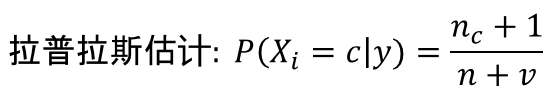

𝑛: 属于类𝑦的训练实例数, $𝑛_𝑐$: $𝑋_𝑖$ = 𝑐 且 𝑌 = 𝑦 的实例数, 𝑣: 属性$𝑋_𝑖$所能取的值的总数


采用拉普拉斯估计修改上述的预测函数

In [109]:
def new_predict(X_test,X):
    result = dict()  # 预测结果
    for c in classes:
        p_x_y = 1
        p_y = class_prior[c]
        n = len(X) * p_y
        for i in X_test.items():
            nc = prior[tuple(list(i)+[c])]  * n
            p_x_y *= (nc + 1) / (n + len(X[i[0]].unique()))
        result[c] = p_y * p_x_y
    return result

In [110]:
print(new_predict(X_test2,X))     #预测结果


{'no': 0.004555393586005831, 'yes': 0.011806375442739082}
